<h2 style="text-align: center;">НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ 
<br/>МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ</h2>
</br>
<h3 style="text-align: center;">Кафедра Паровых и Газовых Турбин</h3>

</br>
</br>
</br>
</br>
</br>

<h1 style="text-align: center;">Курсовая работа по курсу:</h1>
<h1 style="text-align: center;">«Паровые и газовые турбины»</h1>

</br>
</br>
</br>
</br>
</br>

<h5 style="text-align: right;">Студент: Бонадыков Никита Михайлович</h5>
<h5 style="text-align: right;">Группа: ТФэ-01-20</h5>

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

<h5 style="text-align: center;">Москва 2023</h5>

### Вариант №2

## $\space$ Дано:
* $P_0 = 24 \space МПа $ - Начальное давление
* $t_0 = 555 ^\circ C$ -  Начальная температура
* $P_{пп} = 3.66 \space МПа$ -  Температура промперегрева 
* $t_{пп} = 552 ^\circ C$ -  Давление промперегрева
* $P_{к} = 3.4 \space кПа$ -  Давление в конденсаторе
* $t_{п.в.} = 271^\circ C$ -  Температура питательной воды
* $N_{э} = 840 \space МВт$ -  Электрическая мощность
* $z = 9 \space шт$  Число регенеративных подогревателей
* $d_{р.с.} = 1.2 \space м$  Средний диаметр
* $n = 60 \space C ^{-1}$  Частота вращения ротора турбины
* $H_{0} = (90-110) \space кДж/кг$ -  Располaгаемый теплоперепад
* $\eta_{oi} = 85  \space % $ КПД цилиндров турбины
* $\eta_{мех} = 85  \space % $ Механический КПД турбины
* $\eta_{эг} = 85  \space % $ КПД электрического генератора

In [1]:
#Импорт библиотек
import iapws
from iapws import IAPWS97 as gas
import matplotlib.pyplot as plt
import numpy as np
import math
import Inner_part

In [2]:
#Инициализация всомагательных параметров расчета  
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [3]:
#Дано
electrical_power = 840 * (10 ** 6) # Электрическая мощность    
p0 = 24 * MPa # Начальное давление 
t0 = 555 # Начальная температура 
pk = 3.4 * kPa # Давление в конденсаторе
p_middle = 3.4 * MPa # Давление промперегрева
t_middle = 552 # Температура промперегрева 
p_feed_water = 1.4 * p0 # Давление питательной воды 
t_feed_water = 271 # Температура питательной воды
z = 8 # Число регенеративных подогревателей
internal_efficiency = 0.85 # КПД цилиндров турбины
mechanical_efficiency = 0.992 # Механический КПД турбины
generator_efficiency = 0.99 #КПД электрического генератора
d_sr = 1.2 # Средний диаметр 
n = 60 # Частота вращения ротара турбины 
H0 = np.arange(90,110) # Распологаемый теплоперепад 
p = 0.05 # Степень реактивности 

In [4]:
inlet_mass_flow = Inner_part.complite_inlet_mass_flow(p0,
                                                      t0,
                                                      p_middle,
                                                      t_middle,
                                                      pk,
                                                      p_feed_water,
                                                      t_feed_water,
                                                      internal_efficiency,
                                                      mechanical_efficiency,
                                                      generator_efficiency,
                                                      electrical_power)
condenser_mass_flow = Inner_part.complite_condenser_mass_flow(p0,
                                                              t0,
                                                              p_middle,
                                                              t_middle,
                                                              pk,
                                                              p_feed_water,
                                                              t_feed_water,
                                                              internal_efficiency,
                                                              mechanical_efficiency,
                                                              generator_efficiency,
                                                              electrical_power)

Коэфициент для нахождения коэфициента 0.7034639347535063
Коэфициент с графика0.9
Коэфициент для нахождения коэфициента 0.7034639347535063
Коэфициент с графика0.9


In [5]:
print("Массовый расход в турбину на входе", inlet_mass_flow)
print("Массовый расход в конденсатор:", condenser_mass_flow)

Массовый расход в турбину на входе 659.3819522129576
Массовый расход в конденсатор: 434.98665331279125


In [6]:
point0 = Inner_part.find_point0(p0,t0,p_middle)            
point1 = Inner_part.find_point1(p0,t0,p_middle,internal_efficiency)
point2 = Inner_part.find_point2(p_middle,t_middle,p0,pk,internal_efficiency)
point_middle = Inner_part.find_point_middle(p_middle,t_middle,p0)

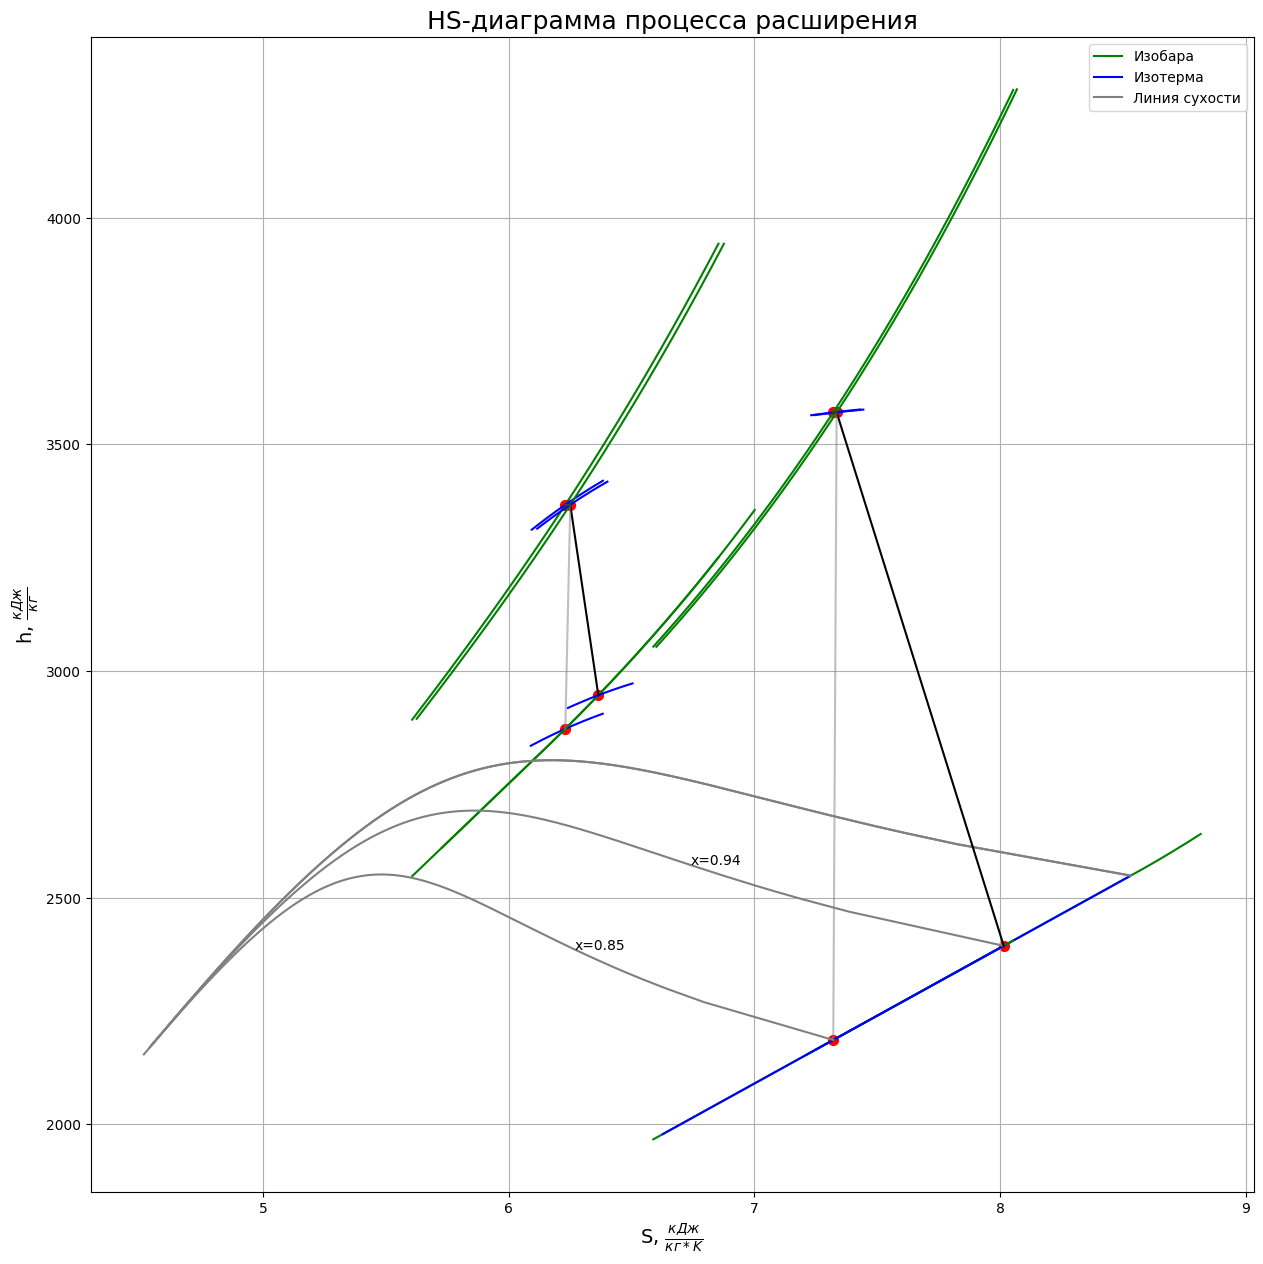

In [7]:
fig, ax  = plt.subplots(1, 1, figsize=(15, 15))
Inner_part.plot_hs_diagram(
    ax,
    points=[point0[0], point0[1], point1[0], point1[1], point_middle[0], point_middle[1], point2[1], point2[0]]
)
Inner_part.plot_process(ax, points=[point0[0], point0[1], point1[1]], color='black')
Inner_part.plot_process(ax, points=[point_middle[0], point_middle[1], point2[1]], color='black')
Inner_part.plot_process(ax, points=[point0[0], point0[1], point1[0]], alpha=0.5, color='grey')
Inner_part.plot_process(ax, points=[point_middle[0], point_middle[1], point2[0]], alpha=0.5, color='grey')

In [8]:
#второй пункт курсового проекта 

point0 = Inner_part.find_point0(p0,t0,p_middle)            
point1 = Inner_part.find_point1(p0,t0,p_middle,internal_efficiency)
point2 = Inner_part.find_point2(p_middle,t_middle,p0,pk,internal_efficiency)
point_middle = Inner_part.find_point_middle(p_middle,t_middle,p0)


u = np.pi * d_sr * n # Окружная скорость на среднем диаметре

H0_c = (1-p) * H0 # Изоэнтальпильный теплоперепад сопловой решотки по параметрам тормажения 

H0_p = p * H0 # Изоэнтальпильный теплоперепад рабочей решотки по статическим параметрам

h1t = point0[0].h - H0_c # Теоретическая энтальпия за сапловой решоткой 

p1 = [] # Давление за сопловой решоткой
for i in h1t:
    p1.append(gas(h = i,s = point0[0].s).P)
    pass

v1t = [] # Удельный обьем за сопловой решоткой(теор)
for i in h1t:
    v1t.append(gas(h = i,s = point0[0].s).v)
    pass

c1t = np.sqrt(2 * H0_c) # Теоретиеская скорость выхода из соплавых лопаток

k = 1.3 # Показатель изоэнтропы??????
a1t = np.sqrt(k* np.array(p1) * np.array(v1t))


M1t = c1t / a1t #Число Маха

mu1 = 0.97
F1 = (inlet_mass_flow * np.array(v1t)) / (mu1 * c1t) # Выходная площадь сопловой решетки (пред) 

alf1_e = 10 # Угол направления скорости

el1 = F1 / (np.pi * d_sr * math.sin(math.radians(alf1_e)))# Произведение el1

e_opt = 4 * np.sqrt(el1) # Оптимальное значение степени парциальности
for i in range(len(e_opt)):
    if e_opt[i] > 0.85: 
        e_opt[i] = 0.85  
        pass
    pass

l1 = el1 / e_opt # Высота сопловых лопаток